In [1]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import seaborn as sns
import os

DATA_DIR = './data/'

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Metrics functions

In [2]:
def mrse(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def re(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def error(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    return np.sqrt(np.mean(np.square(actuals-preds)))

## Reading Nino 3.4 data

In [3]:
filename = 'nino34_data.txt'

## Reading Nino 1.2 data

In [4]:
# filename = 'nino12_data.txt'

In [5]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [6]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951.0 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952.0 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953.0 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954.0 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955.0 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956.0 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957.0 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958.0 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45

## Filtering data to have 1950 - 2008

In [7]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [8]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45, 26.75, 26.6]
1959 [27.07, 27.18, 27.47, 27.88, 27.7, 27.37, 26.44, 26.09, 25.92, 26.24, 26.04, 26.1]
1960 [26.27, 26.29, 26.98, 27.49, 27.68, 27.24, 26.88, 26.7, 26.44, 26.22, 26.26, 26.2]
1961 [26.23, 26.56, 26.94, 27.36,

## Reading Nino 3.4 Anomaly data

In [9]:
# filename = 'nino34_anomalies.txt'

In [10]:
# anomaly_data = open(DATA_DIR + filename)
# anomaly_data_dict = {}

# for line in anomaly_data.readlines():  
#     _,year,value = line.split(' ')
#     value = float(value[:-2])
#     year = int(float(year))
#     if year in anomaly_data_dict:
#         anomaly_data_dict[year]=anomaly_data_dict[year]+[value]
#     else:
#         anomaly_data_dict.update({year:[value]})

In [11]:
# for key,value in anomaly_data_dict.items():
#     print(key,value)
#     assert len(value) == 12

## Flattening time series data

In [12]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [13]:
assert len(filtered_ts) == (2008-1950+1)*12

In [14]:
# filtered_anomalies = np.array([])
# filtered_anomalies = np.array([np.concatenate((filtered_anomalies,val)) for val in anomaly_data_dict.values()]).flatten()

In [15]:
# assert len(filtered_anomalies) == (2008-1950+1)*12

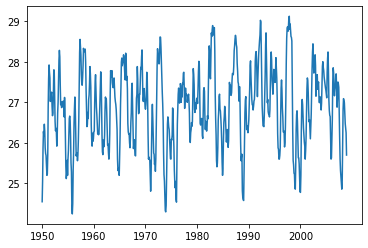

In [16]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

### Train Test Split

In [17]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


## Calculating monthly means across all training years

In [18]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[26.43340426 26.63085106 27.10021277 27.51       27.61638298 27.42085106
 26.98765957 26.58851064 26.47744681 26.43723404 26.42957447 26.37021277]


In [19]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.88340426 -1.57085106 -1.23021277 -1.23       -1.43638298 -0.96085106
 -0.69765957 -0.70851064 -0.73744681 -0.74723404 -0.95957447 -1.17021277]
1951 [-1.19340426 -0.92085106 -0.20021277  0.07        0.30361702  0.30914894
  0.61234043  0.43148936  0.75255319  0.76276596  0.82042553  0.52978723]
1952 [ 0.23659574  0.10914894  0.06978723  0.29        0.17361702 -0.24085106
 -0.45765957 -0.28851064 -0.11744681 -0.17723404 -0.50957447 -0.17021277]
1953 [0.30659574 0.36914894 0.46978723 0.53       0.66361702 0.69914894
 0.44234043 0.35148936 0.53255319 0.43276596 0.45042553 0.62978723]
1954 [ 0.54659574  0.39914894 -0.20021277 -0.87       -0.49638298 -0.62085106
 -0.87765957 -1.15851064 -1.35744681 -1.20723404 -0.85957447 -1.17021277]
1955 [-0.82340426 -0.82085106 -0.88021277 -0.91       -0.95638298 -0.87085106
 -0.83765957 -1.07851064 -1.19744681 -2.02723404 -2.17957447 -1.87021277]
1956 [-1.09340426 -0.87085106 -0.64021277 -0.66       -0.48638298 -0.61085106
 -0.75765957 -0.908510

In [20]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

In [21]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
#training_anomalies = get_data(anomaly_data_dict,training_years)

In [22]:
test_data = get_data(filtered_data,testing_years,subtract_mean=True,means=means)
#test_anomalies = get_data(anomaly_data_dict,testing_years)

In [23]:
len(training_data)#,len(training_anomalies)

564

In [24]:
assert len(training_years)*12 == len(training_data)
#assert len(training_years)*12 == len(training_anomalies)

## Generate Fake Linear data

In [25]:
year_begin=1950
year_end=1996
n_points = (year_end-year_begin+1)*12

In [26]:
p=5

init_val = [0,0,0,0,0]
theta = [0.1,0.2,0.15,0.11,0.21]
sigma = 1
assert len(theta) == p
assert len(init_val) == p

training_data = init_val
for i in range(p,p+n_points):
    w_i = np.random.normal(scale=sigma)
    x_i = sum([training_data[i-k-1]*theta[k] for k in range(p)]) + w_i
    training_data.append(x_i)

In [27]:
test_year_begin=1997
test_year_end=2008
n_test_points = (test_year_end-test_year_begin+1)*12
history = training_data.copy()
test_data = []
for i in range(p+n_points,p+n_points+n_test_points):
    w_i = np.random.normal(scale=sigma)
    x_i = sum([history[i-k-1]*theta[k] for k in range(p)]) + w_i
    history.append(x_i)
    test_data.append(x_i)

In [28]:
training_data = training_data[p:]

## Loading fake linear data

In [29]:
LOAD_DATA = False

training_data_file_name = f'fake_linear_training_data_{p}.npy'
testing_data_file_name = f'fake_linear_test_data_{p}.npy'

if LOAD_DATA:
    training_data = np.load(training_data_file_name)
    test_data = np.load(testing_data_file_name)
else:
    np.save(training_data_file_name,training_data)
    np.save(testing_data_file_name,test_data)

### Plotting training data, mean, acf and pacf

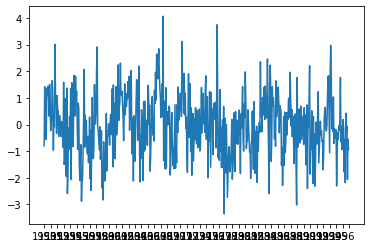

In [30]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

### Plotting test data

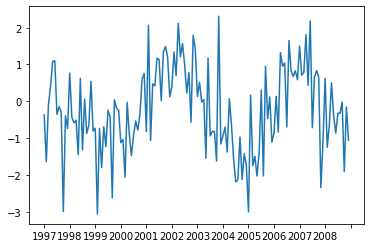

In [31]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

### Plotting train & test data

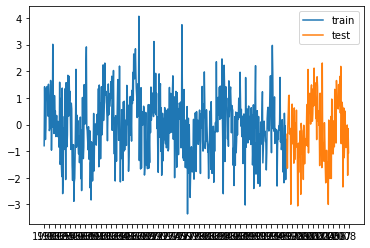

In [32]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

### Plotting ACF and PACF

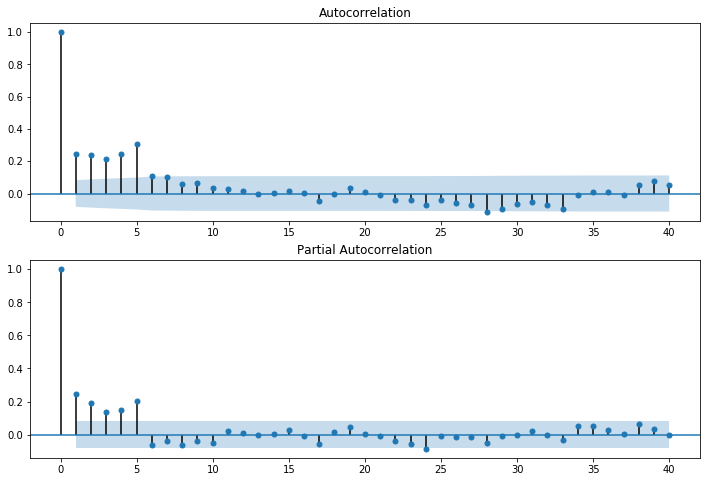

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [34]:
p=5

In [35]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [36]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=True)
print(arma_mod.params)

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

const     -0.036653
ar.L1.y    0.119891
ar.L2.y    0.116313
ar.L3.y    0.081555
ar.L4.y    0.118453
ar.L5.y    0.205148
dtype: float64


### Getting predictions for train set

In [37]:
train_predictions = arma_mod.predict(start=f'{training_years[0]}m1', end=f'{training_years[-1]}m12', dynamic=False)

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


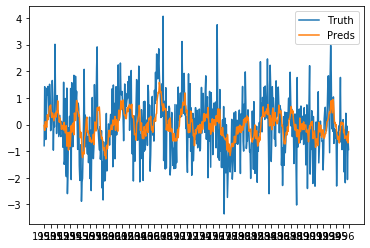

In [38]:
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(train_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

### Getting residuals

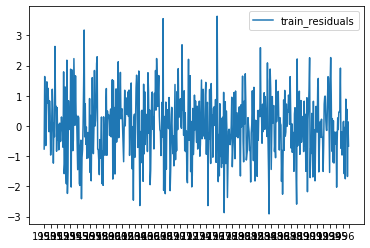

In [39]:
train_residuals = formatted_training_data.values-train_predictions.values
plt.plot(train_residuals,label='train_residuals')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


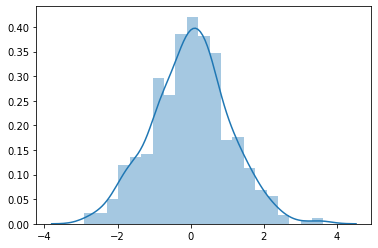

In [40]:
sns.distplot(train_residuals)

### Getting predictions for test set

### ROLLING FORECASTING

In [41]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

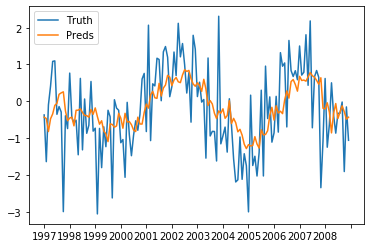

In [42]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### ROLLING STEP FORECASTING

In [43]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(0,len(test_data),6):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast(steps=6)[0]
    yhats = list(output)
    test_predictions+= yhats
    obs = list(test_data[t:t+6])
    history += obs
    #print('predicted=%f, expected=%f' % (yhat, obs))

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

In [44]:
# test_predictions = arma_mod.predict(start=f'{training_years[-1]}m12', end=f'{testing_years[-1]}m11', dynamic=True)

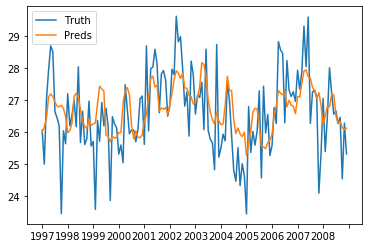

In [45]:
plt.plot(list(range(0,144)),test_data+np.tile(means, len(testing_years)),label='Truth')
plt.plot(list(range(0,144)),test_predictions+np.tile(means, len(testing_years)),label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### SIXTH STEP FORECASTING

In [46]:
p=1
history = list(formatted_training_data.values)#564
test_predictions = []
for t in range(0,len(test_data)):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast(steps=6)[0][-1]
    yhat = output
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, test_data[t+6]))

/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/joshuameisel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

predicted=-0.029451, expected=-0.352863
predicted=-0.029614, expected=-0.143030
predicted=-0.033448, expected=-0.289819
predicted=-0.032361, expected=-2.996026
predicted=-0.031177, expected=-0.392810
predicted=-0.028698, expected=-0.739992
predicted=-0.026704, expected=0.766358
predicted=-0.028409, expected=-0.433633
predicted=-0.028446, expected=-0.584501
predicted=-0.029016, expected=-0.513172
predicted=-0.036303, expected=-1.451936
predicted=-0.034878, expected=0.622686
predicted=-0.036371, expected=-1.318404
predicted=-0.033824, expected=0.063192
predicted=-0.035426, expected=-0.868362
predicted=-0.036489, expected=-0.648405
predicted=-0.037258, expected=0.538626
predicted=-0.040413, expected=-0.809681
predicted=-0.037695, expected=-0.729502
predicted=-0.041327, expected=-3.057655
predicted=-0.040128, expected=-0.735648
predicted=-0.042223, expected=-1.801103
predicted=-0.043099, expected=-0.692421
predicted=-0.041241, expected=-1.231948
predicted=-0.043521, expected=-0.243224
pred

IndexError: list index out of range

In [ ]:
# test_predictions = arma_mod.predict(start=f'{training_years[-1]}m12', end=f'{testing_years[-1]}m11', dynamic=True)

In [ ]:
plt.plot(list(range(0,144)),test_data,label='Truth')
plt.plot(list(range(0,144)),test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [ ]:
plt.plot(list(range(0,138)),test_data[6:],label='Truth')
plt.plot(list(range(0,138)),test_predictions[:-6],label='Preds')

plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### Getting residuals

In [ ]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='residuals')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [ ]:
sns.distplot(test_residuals)

In [ ]:
test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
test_error = error(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')

$$ x_t = \theta_5 x_{t-1}^5 +\theta_4 x_{t-2}^4 +\theta_3 x_{t-3}^3 +\theta_2 x_{t-2}^2 + \theta_1 x_{t-1}$$

## Generate Fake Non Linear data

In [ ]:
year_begin=1950
year_end=1996
n_points = (year_end-year_begin+1)*12

In [ ]:
# p=5

# init_val = [1,1,1,1,1]
# theta = [0.3,0.3,0.4,0.3,0.6]
# sigma = .00015
# assert len(theta) == p
# assert len(init_val) == p

# training_data = init_val
# for i in range(p,p+n_points):
#     w_i = np.random.normal(scale=sigma)
#     x_i = sum([np.power(training_data[i-k-1],p-k)*theta[k] for k in range(p)])# + w_i
#     training_data.append(x_i)

In [ ]:
# test_year_begin=1997
# test_year_end=2008
# n_test_points = (test_year_end-test_year_begin+1)*12
# history = training_data.copy()
# test_data = []
# for i in range(p+n_points,p+n_points+n_test_points):
#     w_i = np.random.normal(scale=sigma)
#     x_i = sum([np.power(history[i-k-1],p-k)*theta[k] for k in range(p)])# + w_i
#     history.append(x_i)
#     test_data.append(x_i)

In [ ]:
# training_data = training_data[p:]

In [54]:
p=2

init_val = [1,1]
theta = [0.3,0.2]
sigma = .15
eta = 1.5
assert len(theta) == p
assert len(init_val) == p

training_data = init_val
for i in range(p,p+n_points):
    w_i = np.random.normal(scale=sigma)
    x_i = sum([training_data[i-k-1]*theta[k] for k in range(p)]) + w_i
    x_i += eta*np.sqrt(training_data[i-1])
    training_data.append(x_i)

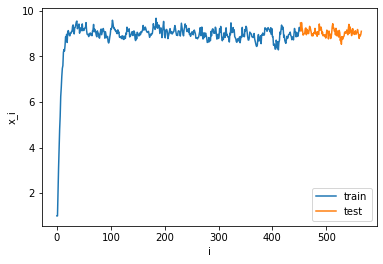

In [69]:
n_i = int(len(training_data) * 0.8)
plt.plot(training_data[:n_i])
plt.plot(range(n_i, len(training_data)), training_data[n_i:])
plt.legend(('train', 'test'))
plt.xlabel('t')
plt.ylabel('x_t')
plt.show()


In [47]:
test_year_begin=1997
test_year_end=2008
n_test_points = (test_year_end-test_year_begin+1)*12
history = training_data.copy()
test_data = []
for i in range(p+n_points,p+n_points+n_test_points):
    w_i = np.random.normal(scale=sigma)
    x_i = sum([history[i-k-1]*theta[k] for k in range(p)]) + w_i
    x_i += eta*np.sqrt(history[i-1])
    history.append(x_i)
    test_data.append(x_i)

IndexError: list index out of range

In [48]:
training_data = training_data[p:]

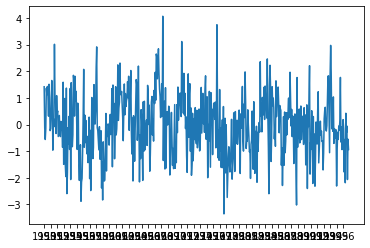

In [49]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

## Loading fake non linear data

In [ ]:
p=5

LOAD_DATA = True

training_data_file_name = f'latest_fake_nonlinear_training_data_{p}.npy'
testing_data_file_name = f'latest_fake_nonlinear_test_data_{p}.npy'

if LOAD_DATA:
    training_data = np.load(training_data_file_name)
    test_data = np.load(testing_data_file_name)
else:
    np.save(training_data_file_name,training_data)
    np.save(testing_data_file_name,test_data)

### Plotting training data, mean, acf and pacf

In [ ]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

### Plotting test data

In [ ]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

In [ ]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [ ]:
p=2
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [ ]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

### Getting predictions for train set

In [ ]:
training_predictions = arma_mod.predict(start=f'{training_years[0]}m1', end=f'{training_years[-1]}m12', dynamic=False)

In [ ]:
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(training_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

### Getting training residuals

In [ ]:
training_residuals = formatted_training_data.values-training_predictions.values
plt.plot(training_residuals,label='training_residuals')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

In [ ]:
sns.distplot(training_residuals)

### Getting predictions for test set

In [ ]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
#test_predictions = arma_mod.forecast(steps=len(test_data))[0]

In [ ]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### ROLLING STEP FORECASTING

In [ ]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(0,len(test_data),6):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast(steps=6)[0]
    yhats = list(output)
    test_predictions+= yhats
    obs = list(test_data[t:t+6])
    history += obs
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
# test_predictions = arma_mod.predict(start=f'{training_years[-1]}m12', end=f'{testing_years[-1]}m11', dynamic=True)

In [ ]:
plt.plot(list(range(0,144)),test_data,label='Truth')
plt.plot(list(range(0,144)),test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### Getting test residuals

In [ ]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='test_residuals')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [ ]:
sns.distplot(test_residuals)

In [ ]:
test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
test_error = error(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')

## Generate GARCH Fake Non Linear data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def garch(ω, α, β, n_out=1000):
    p = len(α)
    q = len(β)

    # Since the first max(p, q) number of points are not generated from the garch
    # process, the first points are garbage (possibly extending beyond max(p, q)),
    # so we drop n_pre > max(p, q) number of points.
    n_pre = 1000
    n = n_pre + n_out

    # Sample noise
    ɛ = np.random.normal(0, 1, n)

    y = np.zeros(n)
    σ = np.zeros(n)

    # Pre-populate first max(p, q) values, because they are needed in the iteration.
    for k in range(np.max([p, q])):
        σ[k] = np.random.normal(0, 1)
        y[k] = σ[k] * ɛ[k]

    # Run the garch process, notation from
    # http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf
    for k in range(np.max([p, q]), n):
        α_term = sum([α[i] * y[k-i]**2 for i in range(p)])
        β_term = sum([β[i] * σ[k-i]**2 for i in range(q)])
        σ[k] = np.sqrt(ω + α_term + β_term)
        y[k] = σ[k] * ɛ[k]

    return y[n_pre:]


# Make a cumulative series from a "delta series".
def delta_to_cum(ys):
    ys_cum = []
    y_cum = 0
    for y in ys:
        y_cum += y
        ys_cum.append(y_cum)
    return ys_cum


# Define a garch(1,1) process
ω = 0.1
α = [0.3]
β = [0.2]
y = garch(ω, α, β)
x = range(len(y))

# The resulting series looks like stock returns and
# the cumulative series looks like stock prices.
plt.subplot(1,2,1)
plt.plot(x, y)
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(x, delta_to_cum(y))
plt.title('Prices')
plt.show()

In [ ]:
cumsum = delta_to_cum(y)
training_data = y[:n_points]
test_data = y[n_points:n_points+n_test_points]

In [ ]:
p=5
LOAD_DATA = True

training_data_file_name = f'garch2_training_data_{p}.npy'
testing_data_file_name = f'garch2_test_data_{p}.npy'

if LOAD_DATA:
    training_data = np.load(training_data_file_name)
    test_data = np.load(testing_data_file_name)
else:
    np.save(training_data_file_name,training_data)
    np.save(testing_data_file_name,test_data)

### Plotting training data, mean, acf and pacf

In [ ]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

### Plotting test data

In [ ]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.show()

In [ ]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),labels=list(training_years)+list(testing_years))
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [ ]:
p=2
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [ ]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

### Getting predictions for train set

In [ ]:
training_predictions = arma_mod.predict(start=f'{training_years[0]}m1', end=f'{training_years[-1]}m12', dynamic=False)

In [ ]:
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(training_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

### Getting training residuals

In [ ]:
training_residuals = formatted_training_data.values-training_predictions.values
plt.plot(training_residuals,label='training_residuals')
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.legend()
plt.show()

In [ ]:
sns.distplot(training_residuals)

### Getting predictions for test set

In [ ]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### ROLLING STEP FORECASTING

In [ ]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(0,len(test_data),6):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast(steps=6)[0]
    yhats = list(output)
    test_predictions+= yhats
    obs = list(test_data[t:t+6])
    history += obs
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
plt.plot(list(range(0,144)),test_data,label='Truth')
plt.plot(list(range(0,144)),test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

### Getting test residuals

In [ ]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='test_residuals')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [ ]:
sns.distplot(test_residuals)

In [ ]:
test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
test_error = error(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')